In [1]:
import numpy as np
from scipy.integrate import quad

def rv_pmode_residual_rms(exptimes,
                          teff, logg, mstar, rstar,
                          readtime=0.0, nobs=1,
                          method='chaplin', nmodes=13,
                          # Solar reference values
                          nu_max_sun=3100.0, delta_nu_sun=134.9,
                          a_max_sun=0.19, c_env_sun=331.0,
                          logg_sun=4.44, teff_sun=5777.0,
                          S=(1.0, 1.35, 1.02, 0.47)):
    """
    Return p-mode residual RV RMS (m/s) as a function of exposure time.

    Parameters
    ----------
    exptimes : float or array-like
        Exposure time(s) in seconds (single value or list/array).
    teff, logg : float
        Effective temperature (K) and log10 surface gravity (cgs) of the star.
    mstar, rstar : float
        Stellar mass and radius in solar units.
    readtime : float, default 0
        Readout (dead) time between sub-exposures (s). Set >0 with nobs>1 to use Gupta et al. (2022) sequence transfer function.
    nobs : int, default 1
        Number of identical sub-exposures. If 1, treated as a single continuous integration.
    method : {'chaplin','comb'}, default 'chaplin'
        'chaplin' integrates over a Gaussian power envelope (Chaplin et al. 2019).
        'comb' approximates discrete modes (simple spacing assumptions; approximate).
    nmodes : int, default 13
        Number of radial orders (per l ridge) in comb approximation (odd number recommended).
    S : 4-tuple
        Spatial response factors (l=0..3).

    Returns
    -------
    residual_rms : ndarray or float
        Residual p-mode RMS velocity (m/s) after temporal averaging for each exposure time.
        Returns a float if input exptimes was scalar.
    """

    # Make array
    scalar_input = np.isscalar(exptimes)
    exptimes = np.atleast_1d(exptimes).astype(float)

    # --- Scaling relations (Chaplin et al. 2019) ---
    nu_max = nu_max_sun * 10.0**(logg - logg_sun) / np.sqrt(teff / teff_sun)
    a_max = a_max_sun * (teff / teff_sun)**4 / 10.0**(logg - logg_sun)
    if teff < teff_sun:
        c_env = c_env_sun * (nu_max / nu_max_sun)**0.88
    else:
        c_env = c_env_sun * (nu_max / nu_max_sun)**0.88 * (1.0 + (teff - teff_sun)/1667.0)
    delta_nu = delta_nu_sun * np.sqrt(mstar / rstar**3)

    S = np.array(S, dtype=float)
    S2_sum = np.sum(S**2)

    def delta_nu_func():
        return delta_nu

    # --- Transfer function ---
    def transfer_eta(nu_microHz, exptime_sec):
        if readtime == 0 or nobs == 1:
            # Continuous exposure: eta = sinc(nu / nu_exp), nu_exp = 1e6 / t
            nu_exp = 1e6 / exptime_sec
            return np.abs(np.sinc(nu_microHz / nu_exp))
        else:
            # Sequence (Gupta et al. 2022, Eq. 23)
            exptime = exptime_sec
            f = nu_microHz * 1e-6  # Hz
            m_idx = np.arange(nobs)
            phase = (2*m_idx - nobs + 1) * np.pi * f[:, None]
            eta_c = np.exp(phase * exptime * 1j) * np.exp(phase * readtime * 1j)
            eta_c_sum = np.sum(eta_c, axis=1).real
            with np.errstate(divide='ignore', invalid='ignore'):
                pref = np.sin(np.pi * f * exptime) / (np.pi * f * (exptime * nobs))
            pref[f == 0.0] = 1.0 / nobs
            return pref * np.abs(eta_c_sum)

    # --- Power spectral density envelope ---
    def envelope_power(nu_microHz):
        return a_max**2 * S2_sum * np.exp(-0.5 * (nu_microHz - nu_max)**2 / c_env**2)

    # --- Integrand for Chaplin method: (eta^2 * P_env) / delta_nu ---
    def integrand_chaplin(nu_microHz, nu_exp, exptime_sec):
        eta = transfer_eta(np.array([nu_microHz]), exptime_sec)[0]
          # P_env
        p = envelope_power(nu_microHz)
        return (eta**2 * p) / delta_nu_func()

    # --- Discrete comb (approximate) ---
    def comb_integral(exptime_sec):
        # Build mode centers (approximate small separations)
        n_indices = np.arange(-nmodes//2, nmodes//2 + 1)
        nu_n = nu_max + n_indices * delta_nu
        d01 = 0.5 * delta_nu
        eps = delta_nu / 10.0  # crude small spacing
        nu_l0 = nu_n[:-1] + d01
        nu_l1 = nu_n
        nu_l2 = nu_n[:-1] + d01 - eps
        nu_l3 = nu_n - eps
        sets = [nu_l0, nu_l1, nu_l2, nu_l3]
        weights = S**2 / S2_sum
        integral = 0.0
        for lset, w in zip(sets, weights):
            if len(lset) == 0:
                continue
            eta = transfer_eta(lset, exptime_sec)
            p = a_max**2 * np.exp(-0.5 * (lset - nu_max)**2 / c_env**2)
            # Each mode contributes eta^2 * p * delta_nu * w
            integral += np.sum(eta**2 * p * delta_nu * w)
        return integral

    residuals = np.empty_like(exptimes)
    # Pre-compute integration bounds for chaplin
    # ±N * c_env around nu_max; N=~(nu_max/c_env -3) in original code; simpler: 6 * c_env span
    N_span = 6.0
    nu_min = max(0.0, nu_max - N_span * c_env)
    nu_max_lim = nu_max + N_span * c_env

    for i, texp in enumerate(exptimes):
        if method == 'chaplin':
            # Integrate envelope * filter
            integral_val = quad(integrand_chaplin, nu_min, nu_max_lim,
                                args=(1e6/texp, texp), limit=200)[0]
        elif method == 'comb':
            integral_val = comb_integral(texp)
        else:
            raise ValueError("method must be 'chaplin' or 'comb'")
        residuals[i] = np.sqrt(integral_val)

    if scalar_input:
        return float(residuals[0])
    return residuals

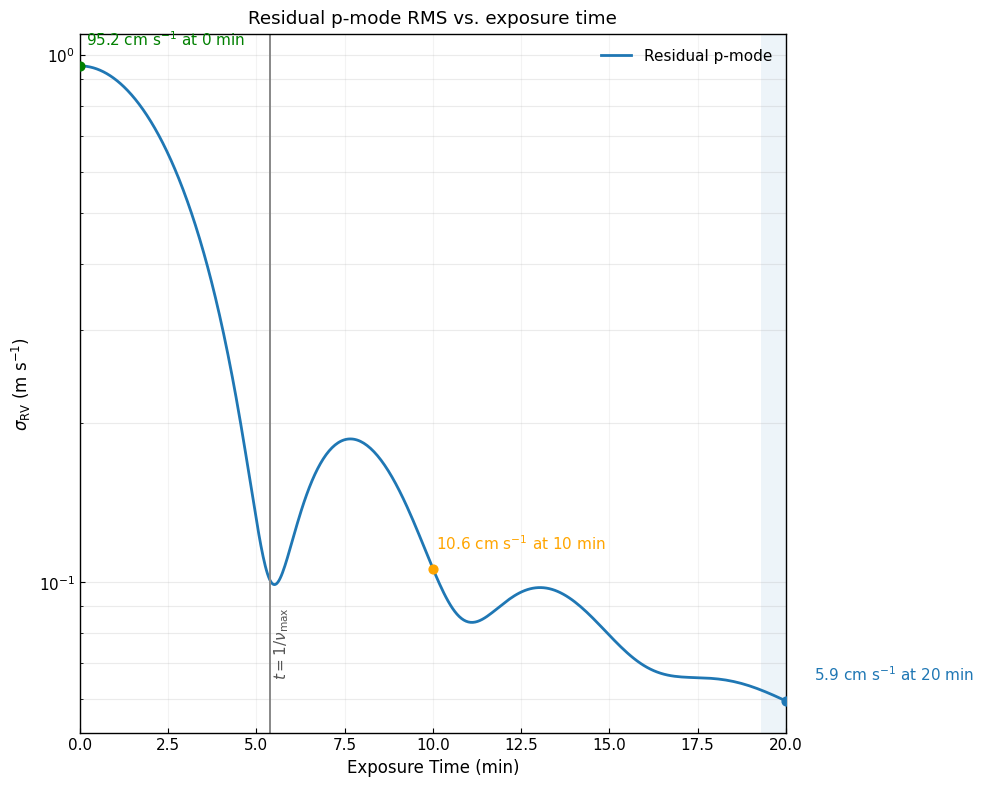

In [4]:
import matplotlib.pyplot as plt
# from p_mode_residual_curve import rv_pmode_residual_rms

# ----------------------------
# Stellar (Sun-like)
# ----------------------------
teff  = 5777.0
logg  = 4.44
mstar = 1.0
rstar = 1.0

# Exposure grid: extend to 20 min to match figure aesthetic
exptimes = np.logspace(0, np.log10(20*60), 1200)  # 1 s to 1200 s (20 min)

# P-mode residuals (m/s)
rms = rv_pmode_residual_rms(exptimes, teff, logg, mstar, rstar)

# ν_max (μHz) and characteristic timescale
nu_max_sun = 3100.0  # μHz
nu_max = nu_max_sun * 10**(logg - 4.44) / np.sqrt(teff / 5777.0)  # μHz
t_vmax_sec = 1.0 / (nu_max * 1e-6)         # seconds
t_vmax_min = t_vmax_sec / 60.0

# ----------------------------
# Identify trough AFTER t_vmax
# ----------------------------
mask_after = exptimes >= t_vmax_sec
if mask_after.any():
    idx_local = np.argmin(rms[mask_after])
    exptime_trough_sec = exptimes[mask_after][idx_local]
    rms_trough = rms[mask_after][idx_local]
else:
    exptime_trough_sec = exptimes[np.argmin(rms)]
    rms_trough = rms.min()
exptime_trough_min = exptime_trough_sec / 60.0

# Define a "near-optimal" region: where residual ≤ 1.05 * trough value and t ≥ t_vmax
optimal_mask = (exptimes >= t_vmax_sec) & (rms <= 1.05 * rms_trough)
# Contiguous region bounds (if any)
if optimal_mask.any():
    opt_inds = np.where(optimal_mask)[0]
    opt_start = exptimes[opt_inds[0]] / 60.0
    opt_end   = exptimes[opt_inds[-1]] / 60.0
else:
    opt_start = opt_end = None

# ----------------------------
# Plot styling
# ----------------------------
plt.rcParams.update({
    "axes.linewidth": 1.0,
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False
})

fig, ax = plt.subplots(figsize=(10, 8))

# P-mode residual curve
ax.plot(exptimes/60.0, rms, color='#1f77b4', lw=2.0, label='Residual p-mode')

# Vertical line at t = 1/ν_max
ax.axvline(t_vmax_min, color='#888888', lw=1.4)
ax.text(t_vmax_min*1.015,
        rms.min()*1.10,
        r'$t = 1/\nu_{\max}$',
        rotation=90, va='bottom', ha='left', color='#555555')

# Shaded optimal band (optional)
if opt_start is not None and opt_end > opt_start:
    ax.axvspan(opt_start, opt_end, color='#1f77b4', alpha=0.08, lw=0)

# Trough marker
ax.scatter([exptime_trough_min], [rms_trough], color='#1f77b4', s=40, zorder=5)
ax.text(exptime_trough_min*1.04,
        rms_trough*1.08,
        f"{rms_trough*100:.1f} cm s$^{{-1}}$ at {exptime_trough_min:.0f} min",
        color='#1f77b4', ha='left', va='bottom')

# --- Label RMS at 10 minutes ---
exptime_10min = 10.0  # minutes
# Find the closest exptime to 10 min
idx_10min = np.abs(exptimes/60.0 - exptime_10min).argmin()
rms_10min = rms[idx_10min]
ax.scatter([exptime_10min], [rms_10min], color='orange', s=40, zorder=6)
ax.text(exptime_10min*1.01,
        rms_10min*1.08,
        f"{rms_10min*100:.1f} cm s$^{{-1}}$ at 10 min",
        color='orange', ha='left', va='bottom')

# --- Label RMS at 0 minutes (really, shortest exposure) ---
exptime_0min = exptimes[0] / 60.0  # in minutes (should be close to 0)
rms_0min = rms[0]
ax.scatter([exptime_0min], [rms_0min], color='green', s=40, zorder=7)
ax.text(exptime_0min + 0.15,
        rms_0min*1.08,
        f"{rms_0min*100:.1f} cm s$^{{-1}}$ at 0 min",
        color='green', ha='left', va='bottom')

# Axes
ax.set_xlim(0, 20)
ax.set_xlabel('Exposure Time (min)')
ax.set_ylabel(r'$\sigma_{\mathrm{RV}}$ (m s$^{-1}$)')
ax.set_yscale('log')
ax.set_title('Residual p-mode RMS vs. exposure time', pad=8)

# Light grid
ax.grid(which='both', axis='y', alpha=0.25)
ax.grid(which='major', axis='x', alpha=0.15)

# Legend
ax.legend(frameon=False, loc='upper right')


fig.tight_layout()
plt.show()

RMS Ratio (10 min / 0 min) for Different Stars:
Star Type            Teff   M/Msun  R/Rsun  Ratio    RMS@0min   RMS@10min 
--------------------------------------------------------------------------------
Sun-like (G2V)       5777   1.00    1.00    0.111    0.95       0.11      
Hot G-dwarf (G0V)    6030   1.10    1.05    0.126    1.22       0.15      
Cool G-dwarf (G5V)   5660   0.92    0.96    0.108    0.87       0.09      
Early K-dwarf (K0V)  5240   0.85    0.85    0.099    0.55       0.06      
Mid K-dwarf (K2V)    4900   0.75    0.75    0.091    0.38       0.03      
Late K-dwarf (K5V)   4350   0.65    0.65    0.069    0.21       0.01      


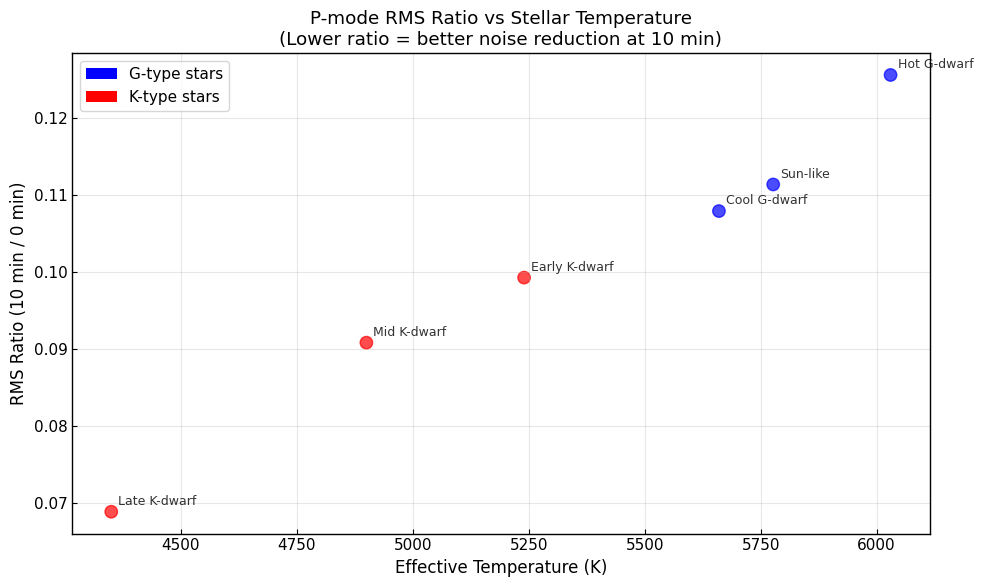


Stars with Best RMS Improvement at 10 minutes:
Late K-dwarf (K5V): 93.1% improvement (ratio = 0.069)
Mid K-dwarf (K2V): 90.9% improvement (ratio = 0.091)
Early K-dwarf (K0V): 90.1% improvement (ratio = 0.099)
Cool G-dwarf (G5V): 89.2% improvement (ratio = 0.108)
Sun-like (G2V): 88.9% improvement (ratio = 0.111)
Hot G-dwarf (G0V): 87.4% improvement (ratio = 0.126)

Note: log g values were calculated from M and R using: log g = 4.44 + log(M/Msun) - 2*log(R/Rsun)


In [3]:
def calculate_rms_ratios(star_parameters, exp_time_10min=600.0, exp_time_0min=1.0):
    """
    Calculate the ratio of residual RMS at 10 minutes to 0 minutes exposure time
    for different stellar parameters.

    Parameters
    ----------
    star_parameters : list of dict
        Each dict contains stellar parameters: 'name', 'teff', 'mstar', 'rstar'
    exp_time_10min : float, default 600.0
        10 minutes in seconds
    exp_time_0min : float, default 1.0
        Reference short exposure time in seconds (approximating 0 min)

    Returns
    -------
    results : dict
        Dictionary with star names as keys and ratio values
    """
    results = {}

    for star in star_parameters:
        # Calculate log g from mass and radius
        # log g = log(GM/R^2) = log(G) + log(M) - 2*log(R) + constant
        # For solar units: log g = log g_sun + log(M/M_sun) - 2*log(R/R_sun)
        logg_sun = 4.44  # Solar log g
        logg = logg_sun + np.log10(star['mstar']) - 2 * np.log10(star['rstar'])
        
        # Calculate RMS at both exposure times
        # Correct parameter order: (exptimes, teff, logg, mstar, rstar)
        rms_0min = rv_pmode_residual_rms(exp_time_0min,
                                        star['teff'], 
                                        logg,
                                        star['mstar'],
                                        star['rstar'])

        rms_10min = rv_pmode_residual_rms(exp_time_10min,
                                         star['teff'], 
                                         logg,
                                         star['mstar'],
                                         star['rstar'])

        # Calculate ratio
        ratio = rms_10min / rms_0min

        results[star['name']] = {
            'ratio': ratio,
            'rms_0min': rms_0min,
            'rms_10min': rms_10min,
            'teff': star['teff'],
            'logg': logg,  # Store calculated log g for reference
            'mstar': star['mstar'],
            'rstar': star['rstar']
        }

    return results

# Define stellar parameters for different G and K dwarfs (no logg needed)
stellar_parameters = [
    # G-type dwarfs
    {'name': 'Sun-like (G2V)', 'teff': 5777, 'mstar': 1.0, 'rstar': 1.0},
    {'name': 'Hot G-dwarf (G0V)', 'teff': 6030, 'mstar': 1.1, 'rstar': 1.05},
    {'name': 'Cool G-dwarf (G5V)', 'teff': 5660, 'mstar': 0.92, 'rstar': 0.96},
    # K-type dwarfs
    {'name': 'Early K-dwarf (K0V)', 'teff': 5240, 'mstar': 0.85, 'rstar': 0.85},
    {'name': 'Mid K-dwarf (K2V)', 'teff': 4900, 'mstar': 0.75, 'rstar': 0.75},
    {'name': 'Late K-dwarf (K5V)', 'teff': 4350, 'mstar': 0.65, 'rstar': 0.65},
]

# Calculate ratios
ratios = calculate_rms_ratios(stellar_parameters)

# Display results
print("RMS Ratio (10 min / 0 min) for Different Stars:")
print("=" * 80)
print(f"{'Star Type':<20} {'Teff':<6} {'M/Msun':<7} {'R/Rsun':<7} {'Ratio':<8} {'RMS@0min':<10} {'RMS@10min':<10}")
print("-" * 80)

for star_name, data in ratios.items():
    print(f"{star_name:<20} {data['teff']:<6.0f} {data['mstar']:<7.2f} {data['rstar']:<7.2f} "
          f"{data['ratio']:<8.3f} {data['rms_0min']:<10.2f} {data['rms_10min']:<10.2f}")

# Create a summary plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Plot: Ratio vs Teff
teff_values = [ratios[name]['teff'] for name in ratios.keys()]
ratio_values = [ratios[name]['ratio'] for name in ratios.keys()]
star_names = list(ratios.keys())

colors = ['red' if 'K' in name else 'blue' for name in star_names]
ax1.scatter(teff_values, ratio_values, c=colors, s=80, alpha=0.7)

for i, name in enumerate(star_names):
    ax1.annotate(name.split('(')[0].strip(),
                 (teff_values[i], ratio_values[i]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.8)

ax1.set_xlabel('Effective Temperature (K)')
ax1.set_ylabel('RMS Ratio (10 min / 0 min)')
ax1.set_title('P-mode RMS Ratio vs Stellar Temperature\n(Lower ratio = better noise reduction at 10 min)')
ax1.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='G-type stars'),
                   Patch(facecolor='red', label='K-type stars')]
ax1.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Additional analysis: Find stars with best improvement at 10 min
print("\nStars with Best RMS Improvement at 10 minutes:")
print("=" * 50)
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1]['ratio'])
for star_name, data in sorted_ratios:
    improvement = (1 - data['ratio']) * 100
    print(f"{star_name}: {improvement:.1f}% improvement (ratio = {data['ratio']:.3f})")

print(f"\nNote: log g values were calculated from M and R using: log g = {4.44:.2f} + log(M/Msun) - 2*log(R/Rsun)")
